# Convolutions

In [9]:
from torch.nn.functional import conv2d
import torch
import numpy as np

Note: `torch.nn.Conv2d` is a `Module` that initializes all parameters i.e. kernel will be learned. Only [functional form](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) can take kernel as input.

## Conv2d

We explore [functional form](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) of `conv2d`. Let's make some inputs and kernels:

In [14]:
torch.manual_seed(14)
x = torch.randn(16, 3, 16, 16)
kernel = torch.randn(10, 3, 3, 3)

basic `Conv2` does what we expect:

In [15]:
y = conv2d(x, kernel)
print(x.shape)
print(y.shape)

torch.Size([16, 3, 16, 16])
torch.Size([16, 10, 14, 14])


Formula for output size for Convolutions is: $[(W−K+2P)/S]+1)$, where [] is the `np.floor`:

In [16]:
def get_output_size(w,k,p,s):
    return int(((w-k+2*p)/s)+1)

In above example:

In [17]:
get_output_size(16, 3, 0, 1)

14

if we want the same size, we could pass `padding='same'`:

In [18]:
y = conv2d(x, kernel, padding='same')
print(x.shape)
print(y.shape)

torch.Size([16, 3, 16, 16])
torch.Size([16, 10, 16, 16])


This works ok for stride=1, but for stride >1 'same' doesn't make sense anymore in PyTorch (raises `RuntimeError: padding='same' is not supported for strided convolutions)`. In TensorFlow however 'same' assumes one needs $width/stride$ size, which in our case should be 8, instead we get expected 7:

In [19]:
y = conv2d(x, kernel, stride=2)
print(x.shape)
print(y.shape)

torch.Size([16, 3, 16, 16])
torch.Size([16, 10, 7, 7])


formula checks out:

In [20]:
get_output_size(16, 3, 0, 2)

7

So what's the padding that we need? We need to do some math:

o = output size
w = width
p = padding
s = stride
if we solve the equation for p:
o = int((w-k+2*p)/s) + 1
o - 1 = int((w-k+2*p)/s)
and here we have a range:
o - 1 = int((w-k+2*p_min)/s)
o - 1 = int((w-k+2*p_max)/s)
solving this:
(o - 1) * s = min = w-k+2*p_min <= w-k+2*p <= w-k+2*p_max = max < o * s
Note that inequality is not symmetric, the top bound is exclusive.
Then:
p_min = ((o-1)*s - w + k) / 2
p_max = (o*s - w + k) / 2
which can both be decimal.
at this point we can just get the ceil of p_min and be happy:
**$p = np.ceil(((o-1)*s - w + k) / 2)$**

In [22]:
def get_lowest_padding(w,k,s):
    o = np.ceil(w/s)
    p = (np.ceil((k - (w - (o-1)*s)) / 2)).astype(int)
    return p

In [23]:
get_lowest_padding(90,15,10)

3

It is quite annoying that padding depends on the width of the input image (this is not always the case though), here is a re-write of the formula where width is defaulted:

In [47]:
def get_padding(kernel_size, stride, width=256):
    """
    Padding that ensures the output_size of ceil(input_size/stride). Assuming square images:
    """
    output_width = np.ceil(width / stride)
    padding = int(np.ceil(((output_width-1) * stride - width + kernel_size) / 2))
    return padding

## Padding visualizations

Let's plot padding for many image widths:

In [48]:
import nbimporter
from Python.functools import partial, plot_function

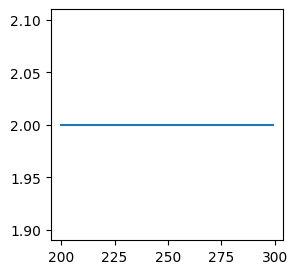

In [49]:
partial_get_padding = partial(get_lowest_padding, k=5, s=2)
x = np.arange(200, 300, 1)
plot_function(partial_get_padding, x)

In [50]:
np.unique(partial_get_padding(np.arange(200,300,1)))

array([2])

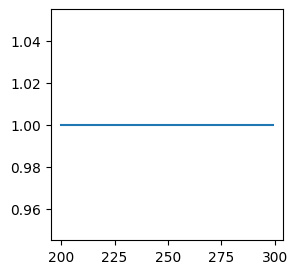

In [51]:
partial_get_padding = partial(get_lowest_padding, k=3, s=1)
x = np.arange(200, 300, 1)
plot_function(partial_get_padding, x)

So this is funny, seems to be independent of the width. Let's look into math again:

o = can be even or odd
p = (np.ceil((k - (1 or 2)) / 2))   # generaly speaking p = (np.ceil((k - (1 to s) / 2))
p = (np.ceil((5 - (1 or 2)) / 2))
p = (np.ceil((4 or 3)/ 2))
p = 2

so that's the reason.

We can also look into limits of p:

`o = np.ceil(w/s)`
`p = (np.ceil(((o-1)*s - w + k) / 2))`
note that p is maximized when `(o-1)*s - w` is highest, i.e. `w - (o-1)*s` is lowest, which is has lowest value of 1 (by definition of o it can't be 0):
**np.ceil((k-s)/2) <= p <= np.ceil((k-1)/2)**

In [52]:
print(get_lowest_padding(90,16,10))  # np.ceil((k-s)/2) = (ceil((16-10)/2) = 3
print(get_lowest_padding(91,16,10))   # np.ceil((k-1)/2) = ceil(15/2) = 8

3
8


Finally, for a special, but common case, w = s*o:

general equations:
o = np.ceil(w/s)
p = (np.ceil(((o-1)*s - w + k) / 2))

then:
p = (np.ceil((k-s) / 2))

so padding doesn't depend on the width in this case. **We will stick with this formula since it makes it simple not to worry about the width, so long our images are divisible by s**.

## Conv2dTranspose

[`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) is used to upsample the input (for example in UNet). These have additional `output_padding` that fills only one-side (useful for those 'same' paddings). It is a non-symmetric padding of the output image that enables us to get an even size image.
